<a href="https://colab.research.google.com/github/pawanraje16/CVDLlab/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


In [ ]:

import zipfile

with zipfile.ZipFile("mango-leaf-disease-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

IMG_SIZE = 64
DATA_DIR = "data"

def load_and_preprocess_images(data_dir, img_size=IMG_SIZE):
    images, labels = [], []
    class_names = os.listdir(data_dir)

    for class_name in class_names:
        image_paths = glob(os.path.join(data_dir, class_name, "*.jpg"))
        for path in tqdm(image_paths, desc=f"Processing {class_name}"):
            img = cv2.imread(path)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
            images.append(img)
            labels.append(class_name)

    images = np.array(images, dtype=np.float32)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    return images, labels, class_names

images, labels, class_names = load_and_preprocess_images(DATA_DIR)


Processing Healthy: 100%|██████████| 500/500 [00:00<00:00, 1687.08it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 100

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = models.Sequential([
            layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)  # mean + log_var
        ])

        self.decoder = models.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(IMG_SIZE//4 * IMG_SIZE//4 * 64, activation='relu'),
            layers.Reshape((IMG_SIZE//4, IMG_SIZE//4, 64)),
            layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, 3, activation='sigmoid', padding='same')
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, latent_dim))
        return self.decode(eps)

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return self.decoder(z)

vae = VAE(latent_dim)


In [ ]:
def compute_vae_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_logit))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    total_loss = reconstruction_loss + kl_loss
    return total_loss


In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = compute_vae_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [ ]:
import time

def train_vae(model, dataset, epochs=200):
    for epoch in range(epochs):
        start = time.time()
        for batch in dataset:
            loss = train_step(model, batch)
        print(f'Epoch {epoch+1}, Loss: {loss.numpy():.4f}, Time: {time.time() - start:.2f}s')


In [ ]:
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(10000).batch(BATCH_SIZE)


In [ ]:
vae = VAE(latent_dim)
train_vae(vae, train_dataset, epochs=200)


Epoch 1, Loss: 0.6846, Time: 3.92s
Epoch 2, Loss: 0.6629, Time: 1.09s
Epoch 3, Loss: 0.6348, Time: 1.26s
Epoch 4, Loss: 0.6273, Time: 1.10s
Epoch 5, Loss: 0.6230, Time: 1.10s
Epoch 6, Loss: 0.6112, Time: 1.09s
Epoch 7, Loss: 0.6313, Time: 1.09s
Epoch 8, Loss: 0.5964, Time: 1.09s
Epoch 9, Loss: 0.5978, Time: 1.09s
Epoch 10, Loss: 0.5951, Time: 1.10s
Epoch 11, Loss: 0.6113, Time: 1.10s
Epoch 12, Loss: 0.6035, Time: 1.10s
Epoch 13, Loss: 0.5925, Time: 1.10s
Epoch 14, Loss: 0.6000, Time: 1.10s
Epoch 15, Loss: 0.6191, Time: 1.11s
Epoch 16, Loss: 0.6106, Time: 1.10s
Epoch 17, Loss: 0.6063, Time: 1.10s
Epoch 18, Loss: 0.5872, Time: 1.10s
Epoch 19, Loss: 0.5996, Time: 1.10s
Epoch 20, Loss: 0.6111, Time: 1.10s
Epoch 21, Loss: 0.5999, Time: 1.10s
Epoch 22, Loss: 0.5888, Time: 1.10s
Epoch 23, Loss: 0.6103, Time: 1.11s
Epoch 24, Loss: 0.5967, Time: 1.10s
Epoch 25, Loss: 0.6085, Time: 1.11s
Epoch 26, Loss: 0.6251, Time: 1.11s
Epoch 27, Loss: 0.5927, Time: 1.11s
Epoch 28, Loss: 0.6031, Time: 1.11s
E

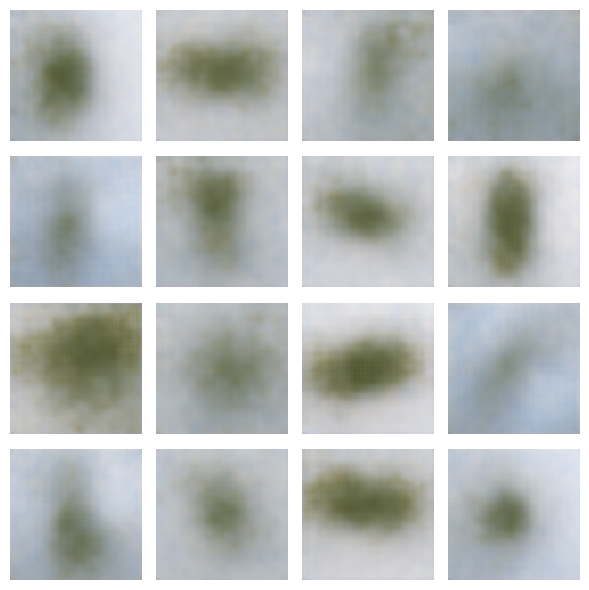

In [ ]:
import matplotlib.pyplot as plt

def show_generated_images(model, n=16):
    z = tf.random.normal([n, latent_dim])
    generated = model.decode(z).numpy()

    plt.figure(figsize=(6, 6))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Generate 16 sample images
show_generated_images(vae)


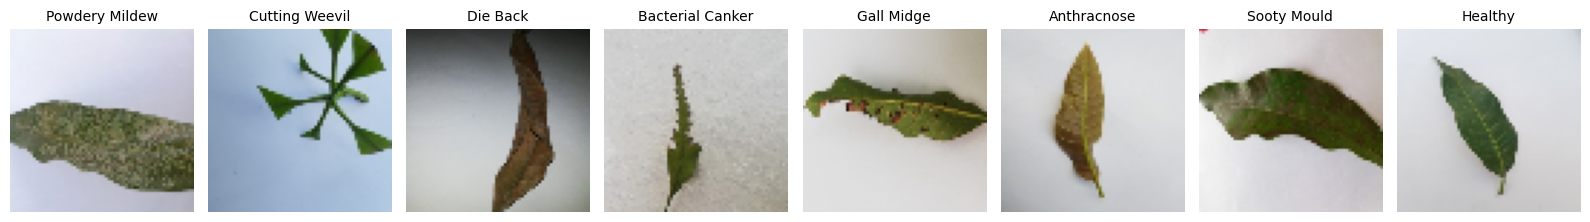

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

DATA_DIR = "data"  # base directory with disease folders
IMG_SIZE = 64       # resize to this for consistency

def show_one_image_per_class(data_dir):
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    n_classes = len(class_dirs)

    plt.figure(figsize=(n_classes * 2, 3))

    for i, class_name in enumerate(class_dirs):
        class_path = os.path.join(data_dir, class_name)
        img_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
        if not img_files:
            continue
        img_path = os.path.join(class_path, img_files[0])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n_classes, i + 1)
        plt.imshow(img)
        plt.title(class_name, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_one_image_per_class(DATA_DIR)
